## **Experimenting with a Quadratic Physics-Informed Neural Network (PINN)**

---
In this notebook we will fit a model to a set of noisy data points generated from the curve $f(x) = ax^2+x + 1$.

The second derivative is $2a$ everywhere:
$$
\frac{d^2f}{dx^2} = 2a
$$

A **Physics-Informed Neural Network (PINN)** is a neural network trained to satisfy two conditions simultaneously:
1.  **Fit the data:** The model's predictions should match the observed data points.
2.  **Obey the physics:** The model's output must satisfy the governing differential equation.

By adding the physical constraint to the training process, we guide the network to learn the true quadratic function.


Note:   The model is more reliable when it is built on large numbers of observations so we will experiment with diffeent $n$ values

In [ ]:
# Importing other libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

### Generate noisy data


In [ ]:
# Defines a line as the ground truth function
def ground_truth(x):
    a = 1  # coefficient for curvature; change as needed
    return a*x**2 + x + 1.0

In [ ]:
# Creates Gaussian noise with mean 0 and variance 0.01 for 5 points
n = 5
g_noise = torch.randn(n,1) * np.sqrt(0.01)

# Generates n number of points between 0 and 1
X = torch.linspace(0, 1, n).view(-1,1)

# Generates y values for corresponding x values and adds Gaussian noise
Y = ground_truth(X) + g_noise

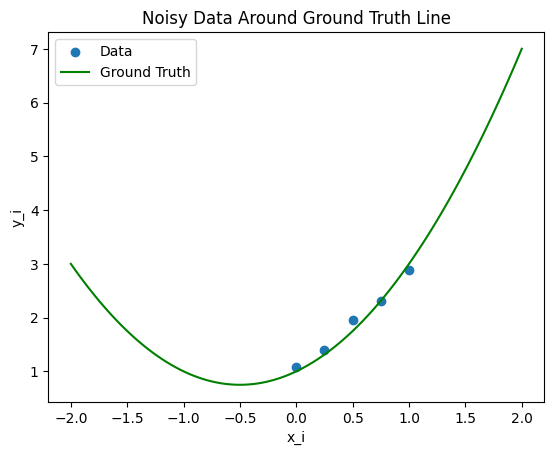

In [ ]:
# Generates x values inside and outside of the initial range
x_plot = torch.linspace(-2, 2, 100).view(-1, 1)

# Plots the noisy data points and ground truth line together
plt.scatter(X.numpy(), Y.numpy(), label='Data')
plt.plot(x_plot.numpy(), ground_truth(x_plot).numpy(), color='green', label='Ground Truth')
plt.xlabel('x_i')
plt.ylabel('y_i')
plt.legend()
plt.title("Noisy Data Around Ground Truth Line")
plt.show()

### Define Neural Network

In [ ]:
#creating the neural network
class Net(nn.Module):
    def __init__(self, d, w):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, w))

        for i in range(d-2):
          self.layers.append(nn.Linear(w, w))

        self.layers.append(nn.Linear(w, 1))


    def forward(self, x):
        for layer in self.layers[:-1]:
          x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

d, w = 2, 20
model = Net(d, w)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

### Training

In the training process, we use two sets of points:
- **$(x_i, y_i)$**: These are the training data points that the model learns to fit.
- **$x_{PINN}$**: These are points sampled from the domain (collocation points) where we enforce the physics-based constraint. They don't have corresponding $y_i$ values.

The loss function consists of two components:

1.  **Data Loss**: This is the mean squared error (MSE) between the model's predictions and the actual data. It ensures the model fits the observed data.
    $$L_{data} = \frac{1}{N_{data}} \sum_{i=1}^{N_{data}} (y^{(i)} - f(x^{(i)}; W))^2$$

2.  **Physics Loss**: This is a regularization term that enforces our prior physical knowledge. Here, we enforce that the second derivative of the function is zero, which is true for a linear function.
    $$L_{physics} = \frac{1}{N_{PINN}} \sum_{j=1}^{N_{PINN}} \left( \frac{d^2}{dx^2} f(x^{(j)}_{PINN};W) \right)^2$$

The total loss is a weighted sum of these two components:
$$L(W) = L_{data} + \eta_{phys} L_{physics}$$
where $\eta_{phys}$ is a regularization parameter.

In [ ]:
#training function
def train(model, criterion, optimizer, epochs, eta_reg):
    data_losses = []
    physics_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # compute f(x) for data loss
        outputs = model(X)
        mse = criterion(outputs, Y)

        # compute f''(x) for PINN loss
        x_pinn = torch.linspace(-2, 2, 100).view(-1, 1)
        x_pinn.requires_grad = True
        y_pinn = model(x_pinn)

        first_derivative = torch.autograd.grad(y_pinn, x_pinn, grad_outputs=torch.ones_like(y_pinn), create_graph=True, retain_graph=True)[0]
        second_derivative = torch.autograd.grad(first_derivative, x_pinn, grad_outputs=torch.ones_like(first_derivative), create_graph=True, retain_graph=True)[0]

########### UPDATE a VALUE HERE, USED IN GROUND TRUTH FUNCTION ############
        a = 1  # same coefficient used in ground_truth
        reg_term = ((second_derivative - 2.0 * a).pow(2)).mean()


        # compute total loss
        total_loss = mse + eta_phys * reg_term

        # compute gradient of loss w.r.t. network parameters
        total_loss.backward()

        # 1 step of gradient descent
        optimizer.step()

        data_losses.append(mse.item())
        physics_losses.append(reg_term.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}, total: {total_loss.item()}, mse: {mse.item()}, reg: {reg_term.item()}")

    return data_losses, physics_losses

Train model with set epochs and regularization $\eta_{phys}$

In [ ]:
epochs = 5000
eta_phys = 1
data_losses, physics_losses = train(model, criterion, optimizer, epochs, eta_phys)

Epoch 1, total: 10.156708717346191, mse: 6.360066890716553, reg: 3.7966415882110596
Epoch 101, total: 6.125526428222656, mse: 1.8630603551864624, reg: 4.262465953826904
Epoch 201, total: 4.976303577423096, mse: 0.46077385544776917, reg: 4.515529632568359
Epoch 301, total: 4.5966668128967285, mse: 0.209569051861763, reg: 4.3870978355407715
Epoch 401, total: 4.309722900390625, mse: 0.14990194141864777, reg: 4.159821033477783
Epoch 501, total: 4.054553508758545, mse: 0.11893399059772491, reg: 3.935619592666626
Epoch 601, total: 3.8096115589141846, mse: 0.09643842279911041, reg: 3.7131731510162354
Epoch 701, total: 3.5666472911834717, mse: 0.0780753642320633, reg: 3.488571882247925
Epoch 801, total: 3.3187246322631836, mse: 0.06460116803646088, reg: 3.2541234493255615
Epoch 901, total: 3.062281608581543, mse: 0.05467505007982254, reg: 3.0076065063476562
Epoch 1001, total: 2.7973272800445557, mse: 0.04688234627246857, reg: 2.7504448890686035
Epoch 1101, total: 2.526522636413574, mse: 0.0409

### Visualization


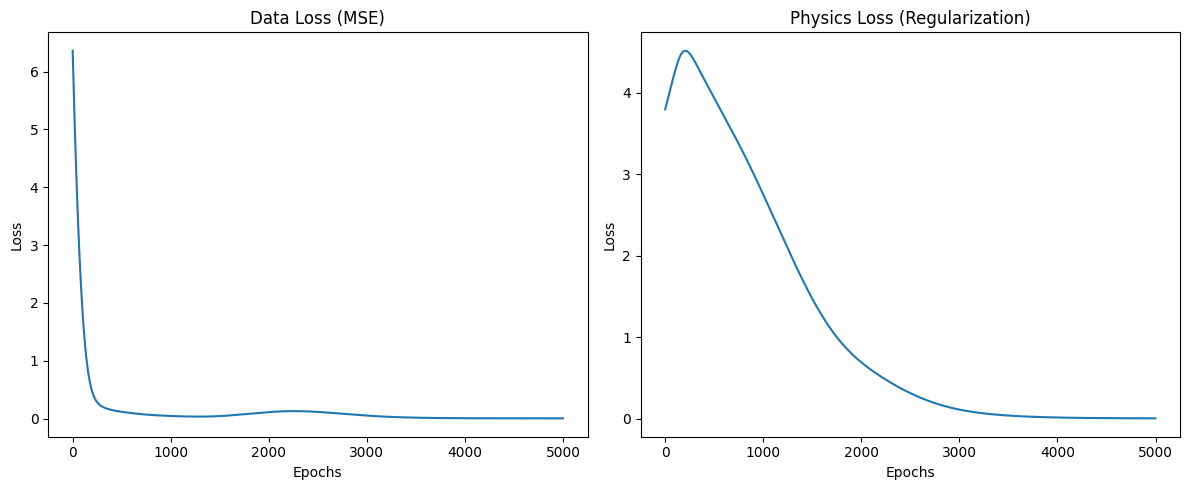

In [ ]:
# Plot loss function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(np.arange(len(data_losses)), data_losses)
ax1.set_title('Data Loss (MSE)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(np.arange(len(physics_losses)), physics_losses)
ax2.set_title('Physics Loss (Regularization)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()

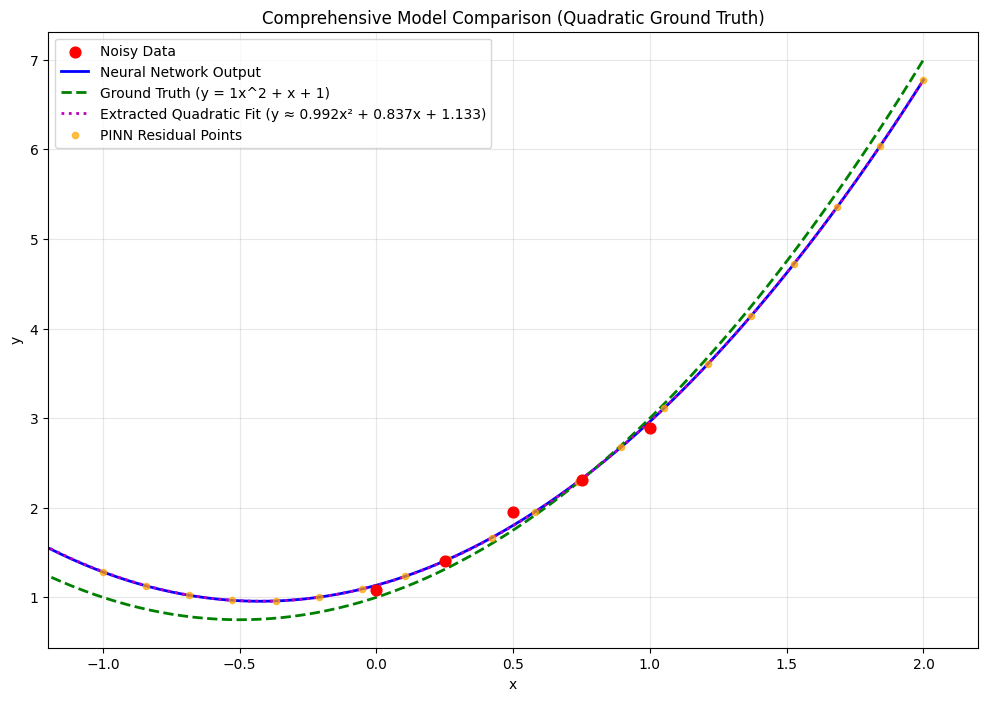

In [ ]:
# Enhanced comparison plot with all requested elements (quadratic version)

########### UPDATE a VALUE HERE, USED IN GROUND TRUTH FUNCTION ############
a = 1  # <- keep this in sync with your ground_truth and physics loss
y_network = model(x_plot)

# Create the comprehensive comparison plot
plt.figure(figsize=(12, 8))

# 1) Noisy data points
plt.scatter(X.detach().numpy(), Y.detach().numpy(), color='red', s=60, label='Noisy Data', zorder=5)

# 2) Network output
plt.plot(x_plot.detach().numpy(), y_network.detach().numpy(),
         color='blue', linewidth=2, label='Neural Network Output')

# 3) Ground truth (quadratic) as dashed line
plt.plot(x_plot.detach().numpy(), ground_truth(x_plot).detach().numpy(),
         'g--', linewidth=2, label=f'Ground Truth (y = {a}x^2 + x + 1)')

# --- Replace the linear extraction with a quadratic extraction ---

# Use a small analysis grid to estimate derivatives and parameters
x_analysis_temp = torch.linspace(-1, 2, 80).view(-1, 1)
x_analysis_temp.requires_grad = True
y_analysis_temp = model(x_analysis_temp)

# First and second derivatives
first_derivative_temp = torch.autograd.grad(
    y_analysis_temp, x_analysis_temp,
    grad_outputs=torch.ones_like(y_analysis_temp),
    create_graph=True, retain_graph=True
)[0]
second_derivative_temp = torch.autograd.grad(
    first_derivative_temp, x_analysis_temp,
    grad_outputs=torch.ones_like(first_derivative_temp),
    create_graph=True, retain_graph=True
)[0]

# Estimate 'a' from f''(x) ≈ 2a  =>  a_hat ≈ mean(f''/2)
a_hat = (second_derivative_temp.mean().item()) / 2.0

# Given y ≈ a_hat*x^2 + b*x + c, solve least squares for b,c:
with torch.no_grad():
    y_net = y_analysis_temp.detach().numpy().reshape(-1, 1)
    x_np  = x_analysis_temp.detach().numpy().reshape(-1, 1)

import numpy as np
X_lin = np.concatenate([x_np, np.ones_like(x_np)], axis=1)                  # columns: [x, 1]
y_lin = y_net - a_hat * (x_np ** 2)                                         # target: y - a_hat x^2
# Solve [b, c] = argmin ||X_lin @ [b, c] - y_lin||_2
bc_hat, *_ = np.linalg.lstsq(X_lin, y_lin, rcond=None)
b_hat = float(bc_hat[0, 0]); c_hat = float(bc_hat[1, 0])

# Plot the extracted quadratic fit
y_extracted_quad = a_hat * (x_plot.detach().numpy() ** 2) + b_hat * x_plot.detach().numpy() + c_hat
plt.plot(x_plot.detach().numpy(), y_extracted_quad,
         'm:', linewidth=2,
         label=f'Extracted Quadratic Fit (y ≈ {a_hat:.3f}x² + {b_hat:.3f}x + {c_hat:.3f})')

# 5) PINN residual points
x_pinn_points = torch.linspace(-1, 2, 20).view(-1, 1)  # widen if your parabola is steep
y_pinn_points = model(x_pinn_points)
plt.scatter(x_pinn_points.detach().numpy(), y_pinn_points.detach().numpy(),
            color='orange', s=20, alpha=0.7, label='PINN Residual Points', zorder=4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comprehensive Model Comparison (Quadratic Ground Truth)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(-1.2, 2.2)  # widen to [-2,2] if a is large
plt.show()

### Post-Processing Analysis

Now we'll analyze the learned network to extract the quadratic relationship parameters and examine their statistical properties.

In [ ]:
# Post-processing: Analyze the learned QUADRATIC relationship y ≈ a*x^2 + b*x + c
# Step 1: set analysis grid
x_analysis = torch.linspace(-2, 2, 80).view(-1, 1)  # more points for stability
x_analysis.requires_grad = True

# Network output
y_analysis = model(x_analysis)

# First and second derivatives
first_derivative = torch.autograd.grad(
    y_analysis, x_analysis,
    grad_outputs=torch.ones_like(y_analysis),
    create_graph=True, retain_graph=True
)[0]
second_derivative = torch.autograd.grad(
    first_derivative, x_analysis,
    grad_outputs=torch.ones_like(first_derivative),
    create_graph=True, retain_graph=True
)[0]

# --- Estimate 'a' from f''(x) ≈ 2a ---
a_hat = (second_derivative.mean().item()) / 2.0

# --- Estimate 'b' and 'c' via least squares: y - a_hat x^2 ≈ b x + c ---
with torch.no_grad():
    x_np = x_analysis.detach().numpy().reshape(-1, 1)
    y_np = y_analysis.detach().numpy().reshape(-1, 1)

import numpy as np
X_lin = np.concatenate([x_np, np.ones_like(x_np)], axis=1)      # columns: [x, 1]
y_lin = y_np - a_hat * (x_np**2)                                # target: y - a_hat x^2
bc_hat, *_ = np.linalg.lstsq(X_lin, y_lin, rcond=None)
b_hat = float(b_hat := bc_hat[0, 0])
c_hat = float(c_hat := bc_hat[1, 0])

# --- Reporting ---
print("=== Second Derivative (Curvature) Analysis ===")
print(f"Second derivative values (first 10): {second_derivative[:10].detach().numpy().flatten()}")
print(f"Mean second derivative: {second_derivative.mean().item():.6f}")
print(f"Estimated a (mean f''/2): {a_hat:.6f}")

print("\n=== Linear Part (given a_hat) Analysis ===")
print(f"Estimated b: {b_hat:.6f}")
print(f"Estimated c: {c_hat:.6f}")

# Optional diagnostics for first derivative spread
print("\n=== First Derivative Diagnostics (not used for params) ===")
print(f"Mean of f'(x): {first_derivative.mean().item():.6f}")
print(f"Std of f'(x): {first_derivative.std().item():.6f}")

# -----------------------------
# ---------- Summary ----------
# -----------------------------
print("\n=== Summary of Extracted Quadratic Relationship ===")
print(f"Learned equation: y ≈ {a_hat:.6f} * x^2 + {b_hat:.6f} * x + {c_hat:.6f}")

########## ! UPDATE a VALUE HERE, USED IN GROUND TRUTH FUNCTION! ###########
# UPDATE Ground truth coefficients to check errors:
a_true, b_true, c_true = 1, 1.0, 1.0
print(f"Ground truth:   y = {a_true:.1f} * x^2 + {b_true:.1f} * x + {c_true:.1f}")
print("Parameter errors:")
print(f"  - |a-a_true| = {abs(a_hat - a_true):.6f}")
print(f"  - |b-b_true| = {abs(b_hat - b_true):.6f}")
print(f"  - |c-c_true| = {abs(c_hat - c_true):.6f}")


=== Second Derivative (Curvature) Analysis ===
Second derivative values (first 10): [1.7705973 1.9234946 2.0149593 2.059423  2.07078   2.061212  2.0405712
 2.0162268 1.9932185 1.9746003]
Mean second derivative: 1.982968
Estimated a (mean f''/2): 0.991484

=== Linear Part (given a_hat) Analysis ===
Estimated b: 0.838739
Estimated c: 1.132123

=== First Derivative Diagnostics (not used for params) ===
Mean of f'(x): 0.838360
Std of f'(x): 2.332818

=== Summary of Extracted Quadratic Relationship ===
Learned equation: y ≈ 0.991484 * x^2 + 0.838739 * x + 1.132123
Ground truth:   y = 1.0 * x^2 + 1.0 * x + 1.0
Parameter errors:
  - |a-a_true| = 0.008516
  - |b-b_true| = 0.161261
  - |c-c_true| = 0.132123


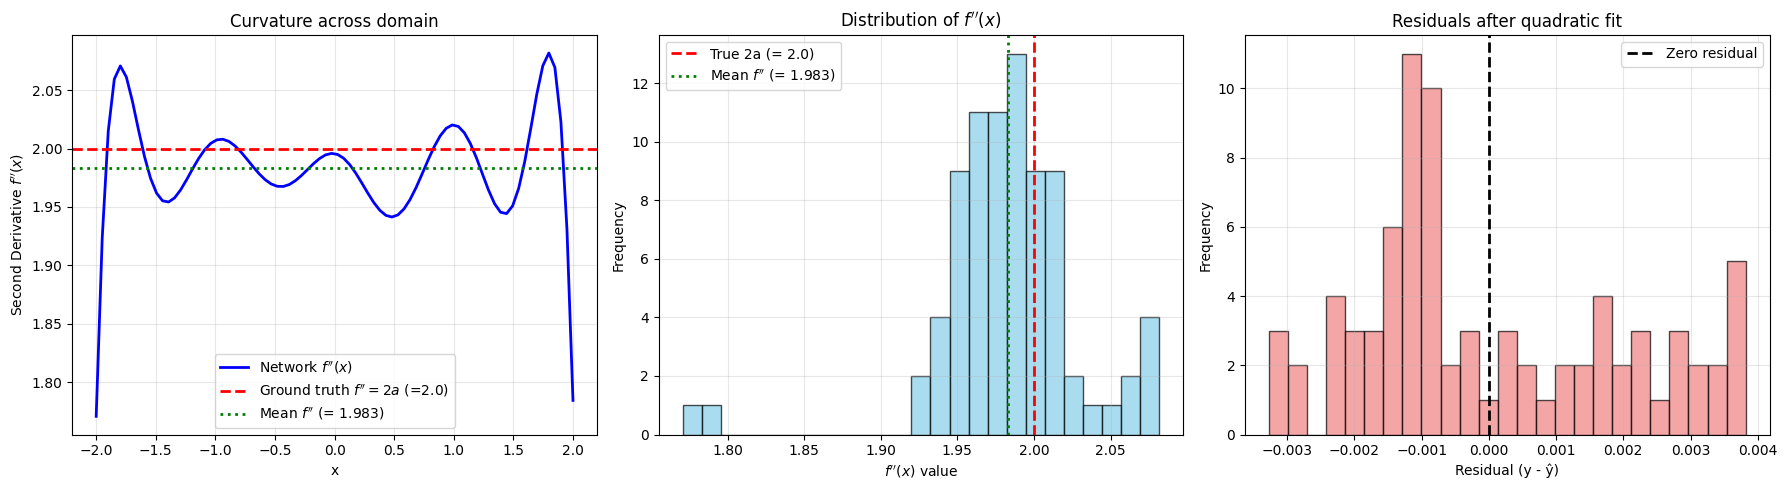


=== Final Summary Statistics (Quadratic) ===
a_hat: 0.991484  | a_true: 1.000000  | |Δa| = 0.008516
b_hat: 0.838739  | b_true: 1.000000  | |Δb| = 0.161261
c_hat: 1.132123  | c_true: 1.000000  | |Δc| = 0.132123
Residuals: mean = 1.192093e-08, std = 1.967775e-03


In [ ]:
# Final visualization: Three specific plots (QUADRATIC version)
import numpy as np
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# ----- Analysis grid and network eval -----
x_analysis = torch.linspace(-2, 2, 80).view(-1, 1)  # widen/narrow as needed
x_analysis.requires_grad = True
y_analysis = model(x_analysis)

# First and SECOND derivatives
first_derivative = torch.autograd.grad(
    y_analysis, x_analysis,
    grad_outputs=torch.ones_like(y_analysis),
    create_graph=True, retain_graph=True
)[0]
second_derivative = torch.autograd.grad(
    first_derivative, x_analysis,
    grad_outputs=torch.ones_like(first_derivative),
    create_graph=True, retain_graph=True
)[0]

# ----- Estimate quadratic parameters -----
# a_hat from f''(x) ≈ 2a  => a_hat ≈ mean(f''/2)
a_hat = (second_derivative.mean().item()) / 2.0

# Given y ≈ a_hat x^2 + b x + c, solve least squares for (b, c)
with torch.no_grad():
    x_np = x_analysis.detach().numpy().reshape(-1, 1)
    y_np = y_analysis.detach().numpy().reshape(-1, 1)

X_lin = np.concatenate([x_np, np.ones_like(x_np)], axis=1)   # columns: [x, 1]
y_lin = y_np - a_hat * (x_np ** 2)                          # target: y - a_hat x^2
bc_hat, *_ = np.linalg.lstsq(X_lin, y_lin, rcond=None)
b_hat = float(bc_hat[0, 0])
c_hat = float(bc_hat[1, 0])

# ----- Plot 1: Second derivative over x (curvature) -----
ax1.plot(x_analysis.detach().numpy(), second_derivative.detach().numpy(),
         'b-', linewidth=2, label="Network $f''(x)$")

########### UPDATE a VALUE HERE, USED IN GROUND TRUTH FUNCTION ############
a_true = 1  # <-- set to match your ground_truth a
ax1.axhline(y=2.0*a_true, color='r', linestyle='--', linewidth=2,
            label=f'Ground truth $f\'\'=2a$ (={2*a_true:.1f})')
ax1.axhline(y=2.0*a_hat, color='g', linestyle=':', linewidth=2,
            label=f'Mean $f\'\'$ (= {2*a_hat:.3f})')
ax1.set_xlabel('x')
ax1.set_ylabel("Second Derivative $f''(x)$")
ax1.set_title("Curvature across domain")
ax1.legend()
ax1.grid(True, alpha=0.3)

# ----- Plot 2: Histogram of second derivative values -----
sd = second_derivative.detach().numpy().flatten()
ax2.hist(sd, bins=25, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=2.0*a_true, color='r', linestyle='--', linewidth=2,
            label=f'True 2a (= {2*a_true:.1f})')
ax2.axvline(x=2.0*a_hat, color='g', linestyle=':', linewidth=2,
            label=f'Mean $f\'\'$ (= {2*a_hat:.3f})')
ax2.set_xlabel("$f''(x)$ value")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of $f''(x)$")
ax2.legend()
ax2.grid(True, alpha=0.3)

# ----- Plot 3: Residuals after quadratic fit -----
y_fit = a_hat*(x_np**2) + b_hat*x_np + c_hat
residuals = (y_np - y_fit).flatten()
ax3.hist(residuals, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.axvline(x=0.0, color='k', linestyle='--', linewidth=2, label='Zero residual')
ax3.set_xlabel('Residual (y - ŷ)')
ax3.set_ylabel('Frequency')
ax3.set_title('Residuals after quadratic fit')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#---------------------------------------
# --------- Summary statistics ---------
#---------------------------------------

########### UPDATE a VALUE HERE, USED IN GROUND TRUTH FUNCTION ############
a_true, b_true, c_true = 1, 1.0, 1.0  # <-- set to match ground_truth coefficients
print("\n=== Final Summary Statistics (Quadratic) ===")
print(f"a_hat: {a_hat:.6f}  | a_true: {a_true:.6f}  | |Δa| = {abs(a_hat - a_true):.6f}")
print(f"b_hat: {b_hat:.6f}  | b_true: {b_true:.6f}  | |Δb| = {abs(b_hat - b_true):.6f}")
print(f"c_hat: {c_hat:.6f}  | c_true: {c_true:.6f}  | |Δc| = {abs(c_hat - c_true):.6f}")
print(f"Residuals: mean = {residuals.mean():.6e}, std = {residuals.std():.6e}")

